In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.robust.robust_linear_model import RLM


In [99]:
# set seed and current working directory
np.random.seed(123)

# current working directory
import os
os.getcwd()
os.chdir('/home/schmilor/GitHub/RiskManangementHUBerlin/')



## Introduction

Index insurances for yield risk management can be used to protect farmers from yield losses due to weather events. The index insurance is based on a weather index, such as the number of days with precipitation above a certain threshold. The insurance pays out if the index value exceeds a certain threshold. The insurance is designed to be simple and transparent, and to reduce the costs of traditional insurance.

Types of index insurance:
- Area-yield index insurance: the index is based on the average yield of a group of farmers in a certain area.	
- Weather index insurance: the index is based on weather data, such as temperature, precipitation, or humidity.
- NDVI index insurance: the index is based on satellite data, such as the Normalized Difference Vegetation Index (NDVI).

The main steps to design an index insurance are:
1. Define the index: select the index, the threshold, and the payout function.

2. Collect data: collect historical data on the index and the payouts.

3. Estimate the parameters: estimate the parameters of the index and the payouts.

4. Validate the model: validate the model using historical data.

5. Design the insurance: design the insurance contract, including the premium and the coverage.

6. Implement the insurance: implement the insurance contract and market it to farmers.



## Yield Data
First, we load the dataset and select the relevant variables. The data contains yield records for German districts from 1979 to 2021 and is publicly available. If you want to use it for your research you can find it here: Duden, C., Nacke, C. & Offermann, F. German yield and area data for 11 crops from 1979 to 2021 at a harmonized spatial resolution of 397 districts. Sci Data 11, 95 (2024). https://doi.org/10.1038/s41597-024-02951-8 


In [100]:
# Load the dataset
data = pd.read_csv('data/Final_data.csv')
# print the first 5 rows of the dataframe
data.head()

,district_no,district,nuts_id,year,var,measure,value,outlier
0,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,ArabLand,area,891.0,0
1,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,district,area,5673.0,0
2,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,area,NaN,0
3,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,yield,NaN,0
4,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,oats,area,42.0,0


In [101]:
# we only want to consider ww which stands for winter wheat
data = data[data['var'] == 'ww']

# and the years > 2000
data = data[data['year'] >= 2000]
# make to wide dataframe based on column measure and value
data = data.pivot(index=['year', 'district_no', 'district', 'nuts_id', 'var', 'outlier'], columns='measure', values='value').reset_index()
data.head()

measure,year,district_no,district,nuts_id,var,outlier,area,yield
0,2000,1001,"Flensburg, kreisfreie Stadt",DEF01,ww,0,NaN,9.86
1,2000,1002,"Kiel, kreisfreie Stadt",DEF02,ww,0,NaN,9.78
2,2000,1003,"Lübeck, kreisfreie Stadt",DEF03,ww,0,NaN,9.40
3,2000,1004,"Neumünster, kreisfreie Stadt",DEF04,ww,0,NaN,7.94
4,2000,1051,"Dithmarschen, Landkreis",DEF05,ww,0,NaN,9.72


## Description of the data

- **Year**: Year of observation
- **District_no**: District number
- **District**: District name
- **nuts_id**: NUTS ID
- **var**: Name of the crop in our case "ww" for winter wheat
- **outlier**: Outlier flag
- **area**: Area of the crop in ha
- **yield**: Yield of the crop in to/ha

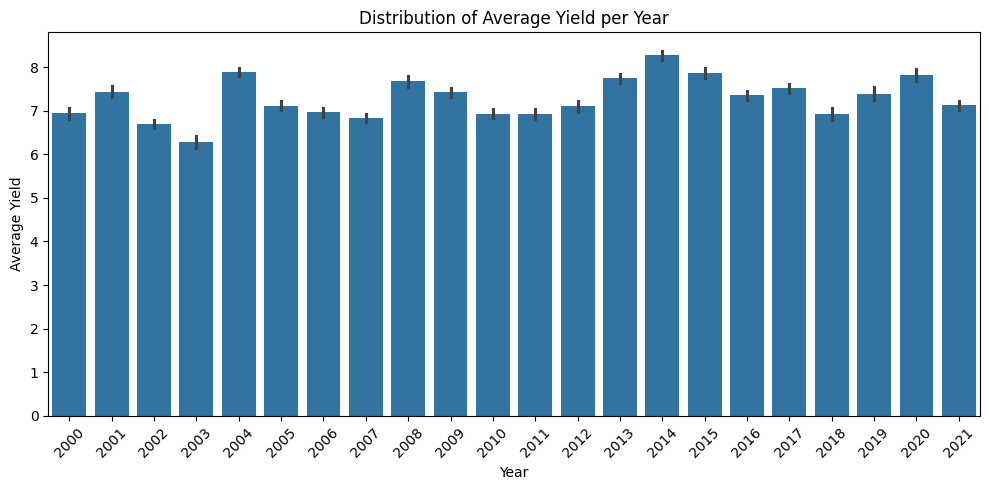

In [102]:
# plot the distribution of average yield per year as barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='year', y='yield')
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.title('Distribution of Average Yield per Year')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.show()


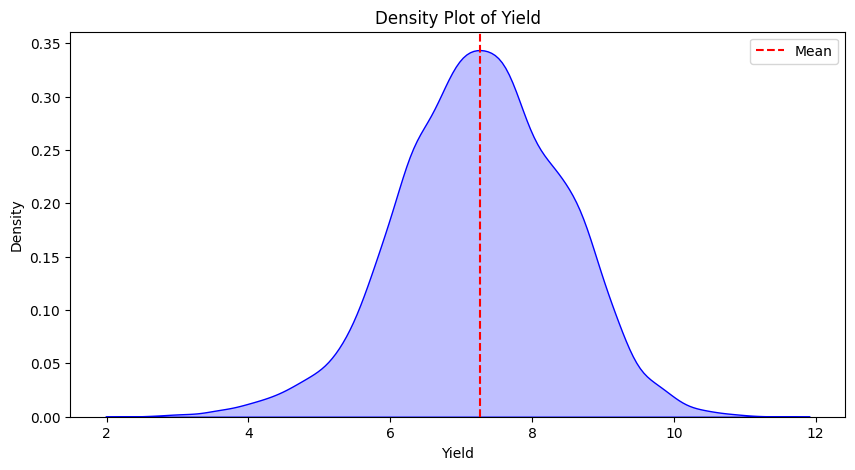

In [103]:
# density plot of yield add vertical line for mean and median

plt.figure(figsize=(10, 5))
sns.kdeplot(data['yield'], fill=True, color='b')
plt.axvline(data['yield'].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('Yield')
plt.ylabel('Density')
plt.title('Density Plot of Yield')
plt.legend()
plt.show()

In [104]:
# identify Bundesland based on first two digits of district_no
# if district_no has not 5 digits add leading zeros
data['district_no'] = data['district_no'].apply(lambda x: '{0:0>5}'.format(x))
data['bundesland'] = data['district_no'].astype(str).str[:2]

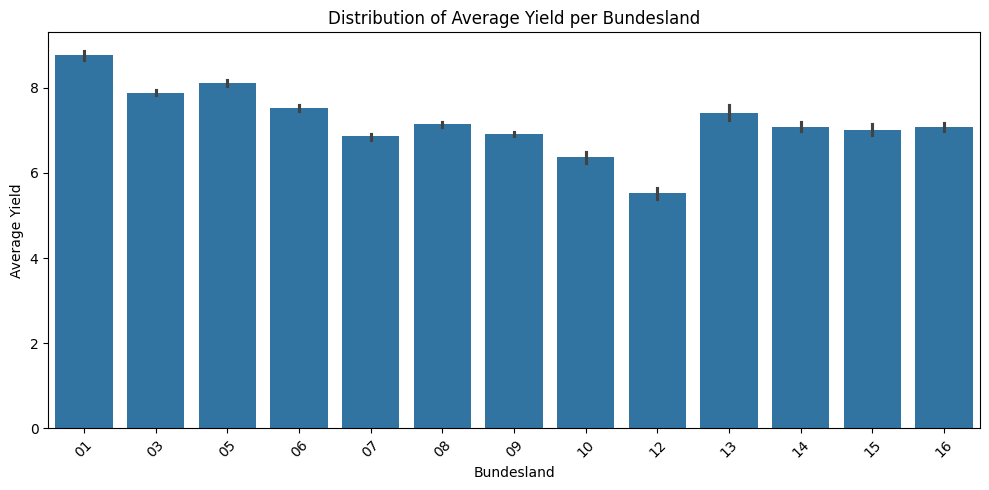

In [105]:
# plot the distribution of average yield per year as barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x='bundesland', y='yield')
plt.xlabel('Bundesland')
plt.ylabel('Average Yield')
plt.title('Distribution of Average Yield per Bundesland')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.show()

### The key features of an area yield insurance are:

1. Payouts are triggered if the realized county average yield falls below a predefined strike yield
2. The payout amount is based on the difference between the realized yield and the strike yield
3. All insured farmers in the county receive the same payout per insured unit

Compared to weather index insurance, area yield insurance has the advantage that the payout is directly linked to the realized yield, which can reduce basis risk. However, it requires reliable and timely yield data at the area level.

In [106]:
# drop na in yield
data = data.dropna(subset=['yield'])
# only consider consider districts with 22 observations
data = data.groupby('district_no').filter(lambda x: len(x) == 22)
# some descriptive statistics
data.describe()
data['yearnumber']  = data['year'] + 1 - 2000

In [107]:
# from year 2000 to 2018 for building up the area yield model
data_train = data[data['year'] <= 2018]
data_test = data[data['year'] >= 2019]

In [108]:
data_train.head(10)

measure,year,district_no,district,nuts_id,var,outlier,area,yield,bundesland,yearnumber
2,2000,01003,"Lübeck, kreisfreie Stadt",DEF03,ww,0,NaN,9.40,01,1
4,2000,01051,"Dithmarschen, Landkreis",DEF05,ww,0,NaN,9.72,01,1
5,2000,01053,"Herzogtum Lauenburg, Landkreis",DEF06,ww,0,NaN,9.11,01,1
6,2000,01054,"Nordfriesland, Landkreis",DEF07,ww,0,NaN,9.46,01,1
7,2000,01055,"Ostholstein, Landkreis",DEF08,ww,0,NaN,10.50,01,1
8,2000,01056,"Pinneberg, Landkreis",DEF09,ww,0,NaN,9.44,01,1
9,2000,01057,"Plön, Landkreis",DEF0A,ww,0,NaN,9.73,01,1
10,2000,01058,"Rendsburg-Eckernförde, Landkreis",DEF0B,ww,0,NaN,9.76,01,1
11,2000,01059,"Schleswig-Flensburg, Landkreis",DEF0C,ww,0,NaN,9.70,01,1
12,2000,01060,"Segeberg, Landkreis",DEF0D,ww,0,NaN,8.73,01,1


## Insurance Design

We will design an area yield insurance for winter wheat in Germany. The insurance will be based on the county average yield of winter wheat. The insurance will pay out if the county average yield falls below a certain threshold. The payout amount will be based on the difference between the realized yield and the threshold yield. All insured farmers in the county will receive the same payout per insured unit.

### Area Yield Index Insurance Design

The areas in this context are the Bundesländer, and the farmers are in the districts. The insurance will be based on the county average yield of winter wheat. The insurance will pay out if the county average yield falls below a certain threshold. The payout amount will be based on the difference between the realized yield and the threshold yield. All insured farmers in the county will receive the same payout per insured unit.

1. **Strike Level Calculation**:
   - Let $( Y_{avg} )$ be the average yield of winter wheat from 2000 to 2018.
   - The strike level $( Y_{strike} )$ is set at 80% of $ Y_{avg} $:
    $$
     Y_{strike} = 0.8 \times Y_{avg}
     $$

2. **Payout Calculation**:
   - Let $ Y_{realized} $ be the realized county average yield in a given year.
   - The insurance will pay out if $ Y_{realized} < Y_{strike} $.
   - The payout amount per insured unit is based on the difference between $Y_{strike}$ and$ Y_{realized} $, multiplied by the fixed price per ton $p $.
   - Given $ p = 180.2 $ EUR per ton, the payout amount $ P_{amount} $ is:
$$
     P_{amount} = 
     \begin{cases} 
     (Y_{strike} - Y_{realized}) \times p & \text{if } Y_{realized} < Y_{strike} \\
     0 & \text{if } Y_{realized} \ge Y_{strike}
     \end{cases}
     $$

Therefore, the total payout for an insured farmer in the county can be calculated using the formulas above, ensuring that all insured farmers receive the same payout per insured unit if the county average yield falls below the set threshold.






In [109]:
# group by bundesland and calculate the mean yield

data_train_grouped = data_train.groupby('bundesland')['yield'].mean().reset_index()
# rename the column to mean_yield_bundesland
data_train_grouped = data_train_grouped.rename(columns={'yield': 'mean_yield_bundesland'})

In [110]:
data_train_grouped.head(10)

,bundesland,mean_yield_bundesland
0,01,8.822018
1,03,7.930806
2,05,8.442942
3,06,7.494180
4,07,6.909684
5,08,7.131278
6,09,7.004513
7,10,6.757632
8,12,5.569925
9,13,7.355435


In [111]:
# merge with data_test
data_test = pd.merge(data_test, data_train_grouped, on='bundesland', how='left')
data_test.head(10)

,year,district_no,district,nuts_id,var,outlier,area,yield,bundesland,yearnumber,mean_yield_bundesland
0,2019,01003,"Lübeck, kreisfreie Stadt",DEF03,ww,0,NaN,8.57,01,20,8.822018
1,2019,01051,"Dithmarschen, Landkreis",DEF05,ww,0,NaN,8.89,01,20,8.822018
2,2019,01053,"Herzogtum Lauenburg, Landkreis",DEF06,ww,0,NaN,8.49,01,20,8.822018
3,2019,01054,"Nordfriesland, Landkreis",DEF07,ww,0,NaN,9.02,01,20,8.822018
4,2019,01055,"Ostholstein, Landkreis",DEF08,ww,0,NaN,9.59,01,20,8.822018
5,2019,01056,"Pinneberg, Landkreis",DEF09,ww,0,NaN,7.97,01,20,8.822018
6,2019,01057,"Plön, Landkreis",DEF0A,ww,0,NaN,8.99,01,20,8.822018
7,2019,01058,"Rendsburg-Eckernförde, Landkreis",DEF0B,ww,0,NaN,9.08,01,20,8.822018
8,2019,01059,"Schleswig-Flensburg, Landkreis",DEF0C,ww,0,NaN,8.74,01,20,8.822018
9,2019,01060,"Segeberg, Landkreis",DEF0D,ww,0,NaN,8.28,01,20,8.822018


In [112]:
import numpy as np

def get_payouts(df, threshold, price):
    
    # calculate the strike level for each row
    strike_level = threshold * df['mean_yield_bundesland']
    
    # calculate the payout for each row
    df[f'payout_{threshold}'] = np.where(df['yield'] < strike_level, (strike_level - df['yield']) * price, 0)
    
    return df


In [113]:
# calculate the payouts for different thresholds
thresholds = [0.9, 0.8, 0.7, 0.6]   
price = 180.2

for threshold in thresholds:
    data_test = get_payouts(data_test, threshold, price)

In [114]:
data_test.head(10)

,year,district_no,district,nuts_id,var,outlier,area,yield,bundesland,yearnumber,mean_yield_bundesland,payout_0.9,payout_0.8,payout_0.7,payout_0.6
0,2019,01003,"Lübeck, kreisfreie Stadt",DEF03,ww,0,NaN,8.57,01,20,8.822018,0.0,0.0,0.0,0.0
1,2019,01051,"Dithmarschen, Landkreis",DEF05,ww,0,NaN,8.89,01,20,8.822018,0.0,0.0,0.0,0.0
2,2019,01053,"Herzogtum Lauenburg, Landkreis",DEF06,ww,0,NaN,8.49,01,20,8.822018,0.0,0.0,0.0,0.0
3,2019,01054,"Nordfriesland, Landkreis",DEF07,ww,0,NaN,9.02,01,20,8.822018,0.0,0.0,0.0,0.0
4,2019,01055,"Ostholstein, Landkreis",DEF08,ww,0,NaN,9.59,01,20,8.822018,0.0,0.0,0.0,0.0
5,2019,01056,"Pinneberg, Landkreis",DEF09,ww,0,NaN,7.97,01,20,8.822018,0.0,0.0,0.0,0.0
6,2019,01057,"Plön, Landkreis",DEF0A,ww,0,NaN,8.99,01,20,8.822018,0.0,0.0,0.0,0.0
7,2019,01058,"Rendsburg-Eckernförde, Landkreis",DEF0B,ww,0,NaN,9.08,01,20,8.822018,0.0,0.0,0.0,0.0
8,2019,01059,"Schleswig-Flensburg, Landkreis",DEF0C,ww,0,NaN,8.74,01,20,8.822018,0.0,0.0,0.0,0.0
9,2019,01060,"Segeberg, Landkreis",DEF0D,ww,0,NaN,8.28,01,20,8.822018,0.0,0.0,0.0,0.0


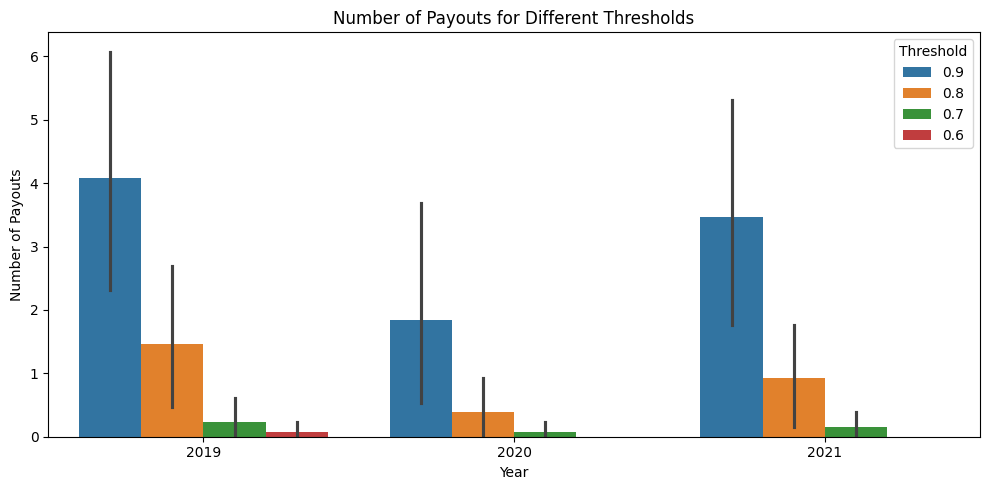

In [115]:
# Visualize the number of payouts for different thresholds, different bundeslands and different years

# count payouts for different thresholds, different bundeslands and different years Payout if > 0
data_test['payout_0.9_yes'] = np.where(data_test['payout_0.9'] > 0, 1, 0)
data_test['payout_0.8_yes'] = np.where(data_test['payout_0.8'] > 0, 1, 0)
data_test['payout_0.7_yes'] = np.where(data_test['payout_0.7'] > 0, 1, 0)
data_test['payout_0.6_yes'] = np.where(data_test['payout_0.6'] > 0, 1, 0)

# now group by bundesland and year and calculate the sum of payouts for different thresholds and visualize the results
data_test_grouped = data_test.groupby(['bundesland', 'year'])[['payout_0.9_yes', 'payout_0.8_yes', 'payout_0.7_yes', 'payout_0.6_yes']].sum().reset_index()
# melt the dataframe
data_test_grouped = pd.melt(data_test_grouped, id_vars=['bundesland', 'year'], value_vars=['payout_0.9_yes', 'payout_0.8_yes', 'payout_0.7_yes', 'payout_0.6_yes'], var_name='threshold', value_name='payout_yes')
# extract the threshold from the column threshold
data_test_grouped['threshold'] = data_test_grouped['threshold'].str.extract('(\d.\d)')

data_test_sum = data_test.groupby(['bundesland', 'year'])[['payout_0.9', 'payout_0.8', 'payout_0.7', 'payout_0.6']].mean().reset_index()
# melt the dataframe
data_test_sum = pd.melt(data_test_sum, id_vars=['bundesland', 'year'], value_vars=['payout_0.9', 'payout_0.8', 'payout_0.7', 'payout_0.6'], var_name='threshold', value_name='payout')

data_test_sum['threshold'] = data_test_sum['threshold'].str.extract('(\d.\d)')

# merge the dataframes
data_test_grouped = pd.merge(data_test_grouped, data_test_sum, on=['bundesland', 'year', 'threshold'], how='left')


# plot the results
plt.figure(figsize=(10, 5))
sns.barplot(data=data_test_grouped, x='year', y='payout_yes', hue='threshold')
plt.xlabel('Year')
plt.ylabel('Number of Payouts')
plt.title('Number of Payouts for Different Thresholds')
plt.legend(title='Threshold')
plt.tight_layout()
plt.show()


In [116]:
data_test_grouped.head(10)

,bundesland,year,threshold,payout_yes,payout
0,01,2019,0.9,1,1.198567
1,01,2020,0.9,0,0.000000
2,01,2021,0.9,1,4.952734
3,03,2019,0.9,7,8.104508
4,03,2020,0.9,11,29.879007
5,03,2021,0.9,7,9.419481
6,05,2019,0.9,3,20.736064
7,05,2020,0.9,2,13.685427
8,05,2021,0.9,3,12.419140
9,06,2019,0.9,0,0.000000


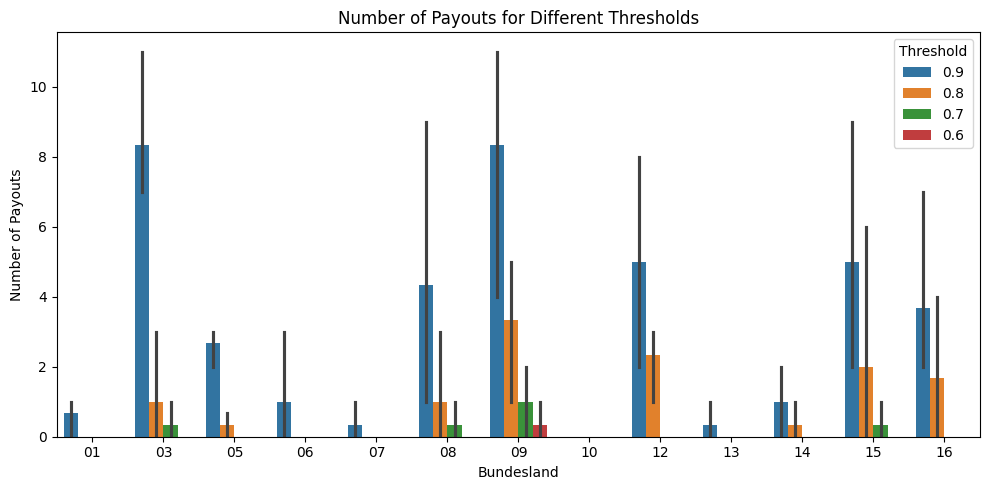

In [75]:
# number of payouts for different bundeslands
# plot the results
plt.figure(figsize=(10, 5))
sns.barplot(data=data_test_grouped, x='bundesland', y='payout_yes', hue='threshold')
plt.xlabel('Bundesland')
plt.ylabel('Number of Payouts')
plt.title('Number of Payouts for Different Thresholds')
plt.legend(title='Threshold')
plt.tight_layout()
plt.show()

In [76]:
# calculate the average payout for different thresholds
data_test_grouped.head()

,bundesland,year,threshold,payout_yes
0,01,2019,0.9,1
1,01,2020,0.9,0
2,01,2021,0.9,1
3,03,2019,0.9,7
4,03,2020,0.9,11
